# souce code utama, dilatih selama 5 iterasi, LR lebih kecil 0,0001
# update terbaru: LR tetap 0,001. lupa ubah saat running code.
# wight imagenetv1 dihapus, oakai weight model sblm pruning


# Cell 1: Import Libraries and Setup Device
"""
This cell imports all the necessary libraries and sets up the device for GPU computation if available.
We are using PyTorch for deep learning, OpenCV for image processing, and Matplotlib/Seaborn for visualization.
"""

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import cv2
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from tqdm import tqdm
import os
import numpy as np
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Cek apakah kode dijalankan di Google Colab
IN_COLAB = 'google.colab' in str(get_ipython())

# Cek apakah GPU tersedia, jika tidak gunakan CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Mount Google Drive jika menggunakan Google Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')


Using device: cuda
Mounted at /content/drive


# Cell 2: Define Data Loading and Preprocessing Functions
"""
This cell contains functions to load and preprocess images from the dataset.
The `load_data` function loads images from the specified directory and assigns labels based on the folder structure.
The `preprocess_image` function applies CLAHE and unsharp masking to enhance image quality.
The `CustomDataset` class integrates these functions and prepares the dataset for use in PyTorch.
"""

In [ ]:
def load_data(dataset_path, subset):
    images = []
    labels = []

    # Tentukan label sesuai dengan subset

    label_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']



    # Pemetaan nama label ke indeks
    label_map = {name: idx for idx, name in enumerate(label_names)}

    subset_path = os.path.join(dataset_path, subset)
    for label_name in label_names:
        image_dir = os.path.join(subset_path, label_name)
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Directory not found: {image_dir}")
        for file_name in os.listdir(image_dir):
            if file_name.endswith('.png'):  # Cek jika file adalah gambar PNG
                image_path = os.path.join(image_dir, file_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Warning: Unable to load image {image_path}")
                    continue
                images.append(image)
                labels.append(label_map[label_name])
                print(f"Loaded image {image_path}")
    return images, labels

def preprocess_image(image):
    if image is None or image.size == 0:
        raise ValueError("Empty image provided for preprocessing")

    # Terapkan CLAHE untuk meningkatkan kontras
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(10, 10))

    clahe_image = clahe.apply(image)

    # Terapkan Gaussian Blur untuk menghaluskan gambar
    #gaussian = cv2.GaussianBlur(image, (9, 9), 10.0)
    # Terapkan Unsharp Masking untuk meningkatkan ketajaman gambar
    #unsharp_image = cv2.addWeighted(clahe_image, 1.5, gaussian, -0.5, 0, clahe_image)
    #unsharp_image = cv2.addWeighted(gaussian, 1.5, gaussian, -0.5, 0)

    return clahe_image

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        try:
            # Proses gambar
            image = preprocess_image(image)
        except ValueError as e:
            print(f"Error preprocessing image at index {idx}: {e}")
            plt.imshow(image, cmap='gray')
            plt.title(f"Label: {label}")
            plt.show()
            raise e
        # Terapkan transformasi jika ada
        if self.transform:
            image = self.transform(image)
        if image.dim() == 2:  # Pastikan gambar memiliki 3 dimensi
            image = image.unsqueeze(0)
        return image, label


# Cell 3: Load and Transform Data
"""
This cell loads the data and applies the necessary transformations.
The dataset is divided into training, validation, and test sets.
Each image is transformed into a 224x224 size tensor suitable for input to the VGG-16 model.
"""

In [ ]:
# Mengatur path dataset, disesuaikan untuk Google Colab atau Jupyter Notebook
dataset_path = '/content/drive/MyDrive/Chest-CT-Data'

# Load data
train_images, train_labels = load_data(dataset_path, 'train')
valid_images, valid_labels = load_data(dataset_path, 'valid')
test_images, test_labels = load_data(dataset_path, 'test')

print(f"Loaded {len(train_images)} training images with {len(train_labels)} labels")
print(f"Loaded {len(valid_images)} validation images with {len(valid_labels)} labels")
print(f"Loaded {len(test_images)} test images with {len(test_labels)} labels")

# Transformasi data untuk persiapan training, validation, dan testing
transform = transforms.Compose([
    transforms.ToPILImage(),             # Ubah dari array NumPy ke gambar PIL
    transforms.Resize((224, 224)),       # Ubah ukuran gambar menjadi 224x224
    #v2.RandomHorizontalFlip(),           # Randomly flip the image horizontally
   # v2.RandomRotation(15),                # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),               # Ubah gambar menjadi Tensor and normalize to [0, 1]
])

# Membuat dataset dan data loader untuk training, validation, dan testing
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
valid_dataset = CustomDataset(valid_images, valid_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # DataLoader untuk training
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False) # DataLoader untuk validasi
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)   # DataLoader untuk testing


Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/ad12.png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000104 (10).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000118 (4).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/ad21.png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000107 (9).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000102 (7).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000097 (2).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000106 (10).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000101 (7).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000105 (4).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/ad2.png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/

## Pruning

In [ ]:
# Prune a convolutional layer based on L2 norm
def prune_conv_layer(layer, prune_ratio, in_channels=None):
    out_channels = layer.out_channels
    num_keep = max(1, int(out_channels * (1 - prune_ratio)))

    weight = layer.weight.data.cpu()
    l2_norm = torch.norm(weight.view(weight.size(0), -1), p=2, dim=1)
    top_indices = torch.argsort(l2_norm, descending=True)[:num_keep]

    mask = torch.zeros(out_channels, device=weight.device)
    mask[top_indices] = 1

    layer.weight.data = layer.weight.data[top_indices]
    if layer.bias is not None:
        layer.bias.data = layer.bias.data[top_indices]

    layer.out_channels = num_keep

    if in_channels is not None:
        layer.weight.data = layer.weight.data[:, :in_channels]
        layer.in_channels = in_channels

    return mask, num_keep

# Prune a batch normalization layer
def prune_bn_layer(layer, mask):
    layer.weight.data = layer.weight.data[mask.bool()]
    layer.bias.data = layer.bias.data[mask.bool()]
    layer.running_mean = layer.running_mean[mask.bool()]
    layer.running_var = layer.running_var[mask.bool()]
    layer.num_features = int(mask.sum().item())

# Prune bottleneck block in ResNet
def prune_bottleneck(bottleneck, prune_ratio, in_channels):
    # Prune conv1
    mask1, out1 = prune_conv_layer(bottleneck.conv1, prune_ratio, in_channels)
    prune_bn_layer(bottleneck.bn1, mask1)

    # Prune conv2
    mask2, out2 = prune_conv_layer(bottleneck.conv2, prune_ratio, out1)
    prune_bn_layer(bottleneck.bn2, mask2)

    # Prune conv3
    mask3, out3 = prune_conv_layer(bottleneck.conv3, prune_ratio, out2)
    prune_bn_layer(bottleneck.bn3, mask3)

    # Handle downsample if it exists
    if bottleneck.downsample is not None:
        mask_down, _ = prune_conv_layer(bottleneck.downsample[0], prune_ratio, in_channels)
        prune_bn_layer(bottleneck.downsample[1], mask_down)

    return out3

# Prune each layer in ResNet
def prune_resnet_layer(layer, prune_ratio, in_channels):
    for bottleneck in layer:
        out_channels = prune_bottleneck(bottleneck, prune_ratio, in_channels)
        in_channels = out_channels
    return out_channels

# Prune the entire model
def prune_model_resnet(model, prune_ratio):
    in_channels = 3  # Initial input channels for ResNet
    mask, out_channels = prune_conv_layer(model.features[0], prune_ratio, in_channels)
    prune_bn_layer(model.features[1], mask)

    # Prune ResNet layers (layer1, layer2, layer3, layer4)
    for i in range(4, 8):
        out_channels = prune_resnet_layer(model.features[i], prune_ratio, out_channels)

    # Adjust the classifier input size based on pruned features
    with torch.no_grad():
        # Create a dummy input to get the output size of the features
        dummy_input = torch.randn(1, 3, 224, 224).to(next(model.parameters()).device)
        features_output = model.features(dummy_input)
        flattened_size = features_output.view(features_output.size(0), -1).size(1)

    # Update the Linear layer in the classifier to match the pruned model
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(flattened_size, 512),  # Adjust input size to match the pruned model's output
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, model.classifier[-1].out_features)
    )

    print(f"Adjusted classifier input size to {flattened_size}")
    return model

# Load and prune the model with adjustment to the classifier
def load_and_prune_model_resnet(model_path, prune_ratio):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Resnet50()
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Original model loaded.")

    # Prune the model and adjust the classifier
    pruned_model = prune_model_resnet(model, prune_ratio).to(device)

    return pruned_model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def calculate_model_size(model):
    """
    Calculate the size of the model in megabytes (MB).

    Args:
    - model: The model (before or after pruning).

    Returns:
    - size_in_mb: The size of the model in MB.
    """
    param_size = sum(param.numel() * param.element_size() for param in model.parameters())
    buffer_size = sum(buffer.numel() * buffer.element_size() for buffer in model.buffers())
    size_in_bytes = param_size + buffer_size
    size_in_mb = size_in_bytes / 1024**2  # Convert bytes to megabytes (MB)
    return size_in_mb

# Fungsi untuk memverifikasi pruning model
def verify_pruned_model(model, original_model):
    def calculate_num_params(model):
        return sum(p.numel() for p in model.parameters())

    # Calculate the model sizes
    original_size = calculate_model_size(original_model)
    pruned_size = calculate_model_size(model)
    print(f"Original model size: {original_size:.2f} MB")
    print(f"Pruned model size: {pruned_size:.2f} MB")
    print(f"Size reduction: {original_size - pruned_size:.2f} MB ({(original_size - pruned_size) / original_size * 100:.2f}%)")

    original_params = calculate_num_params(original_model)
    pruned_params = calculate_num_params(model)
    print(f"Original model parameters: {original_params}")
    print(f"Pruned model parameters: {pruned_params}")

    print("\nLayer-wise dimension comparison:")
    for (orig_name, orig_module), (pruned_name, pruned_module) in zip(original_model.features.named_modules(), model.features.named_modules()):
        if isinstance(orig_module, nn.Conv2d) and isinstance(pruned_module, nn.Conv2d):
            print(f"Layer: {orig_name}")
            print(f"  - Original shape: {orig_module.weight.shape}")
            print(f"  - Pruned shape: {pruned_module.weight.shape}")

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import copy

# Custom ResNet50 Class
class Resnet50(nn.Module):
    def __init__(self):
        super(Resnet50, self).__init__()
        resnet_model = resnet50()
        self.features = nn.Sequential(*list(resnet_model.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 4)
        )

    def forward(self, input):
        x = self.features(input)
        x = self.classifier(x)
        return x

In [ ]:
# Load model ResNet50 pretrained
model_resnet = Resnet50()
resnet_path = '/content/drive/MyDrive/best-model-resnet-clahe-0,001-8-70.pth'
model_resnet.load_state_dict(torch.load(resnet_path, map_location=device))

# Buat salinan model asli
resnet_model_copy = copy.deepcopy(model_resnet)

# Prune model dengan pruning ratio tertentu
pruning_amount = 0.1  # Contoh: prune 50% filter
pruned_model_resnet = load_and_prune_model_resnet(resnet_path, pruning_amount)

# Model sekarang sudah di-prune dan siap untuk digunakan
verify_pruned_model(pruned_model_resnet, resnet_model_copy)
torch.save(pruned_model_resnet.state_dict(), '/content/drive/MyDrive/Best-pruning-model/11-iterasi-pruned-resnet-10-0,001.pth')

<ipython-input-6-a007dd481934>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_resnet.load_state_dict(torch.load(resnet_path, map_location=device))
<ipython-input-4-a

Original model loaded.
Adjusted classifier input size to 1843
Original model size: 93.89 MB
Pruned model size: 76.25 MB
Size reduction: 17.64 MB (18.79%)
Original model parameters: 24559172
Pruned model parameters: 19939950

Layer-wise dimension comparison:
Layer: 0
  - Original shape: torch.Size([64, 3, 7, 7])
  - Pruned shape: torch.Size([57, 3, 7, 7])
Layer: 4.0.conv1
  - Original shape: torch.Size([64, 64, 1, 1])
  - Pruned shape: torch.Size([57, 57, 1, 1])
Layer: 4.0.conv2
  - Original shape: torch.Size([64, 64, 3, 3])
  - Pruned shape: torch.Size([57, 57, 3, 3])
Layer: 4.0.conv3
  - Original shape: torch.Size([256, 64, 1, 1])
  - Pruned shape: torch.Size([230, 57, 1, 1])
Layer: 4.0.downsample.0
  - Original shape: torch.Size([256, 64, 1, 1])
  - Pruned shape: torch.Size([230, 57, 1, 1])
Layer: 4.1.conv1
  - Original shape: torch.Size([64, 256, 1, 1])
  - Pruned shape: torch.Size([57, 230, 1, 1])
Layer: 4.1.conv2
  - Original shape: torch.Size([64, 64, 3, 3])
  - Pruned shape: tor

In [ ]:
import time  # Import modul time

# Define the optimizer and loss function
optimizer = optim.SGD(pruned_model_resnet.parameters(), lr=0.001, momentum=0.8)
criterion = nn.CrossEntropyLoss()

# Function to calculate metrics (accuracy, precision, recall, F1-score)
def calculate_metrics(predictions, labels):
    preds = torch.argmax(predictions, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    accuracy = (preds == labels).mean() * 100
    precision = precision_score(labels, preds, average='weighted', zero_division=1)
    recall = recall_score(labels, preds, average='weighted', zero_division=1)
    f1 = f1_score(labels, preds, average='weighted', zero_division=1)

    return accuracy, precision, recall, f1

# Function to train and evaluate the model
def train_and_evaluate(pruned_model, train_loader, valid_loader,  num_epochs=100):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    all_train_precisions = []
    all_train_recalls = []
    all_train_f1s = []
    all_valid_precisions = []
    all_valid_recalls = []
    all_valid_f1s = []

    best_valid_loss = float('inf')

    # Variable to accumulate total training and validation time
    total_train_validation_time = 0

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')

        # Start timer for both training and validation
        start_epoch_time = time.time()

        # Training
        pruned_model_resnet.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        for images, labels in tqdm(train_loader, desc='Training'):
            images, labels = images.to(device), labels.to(device)

            # Convert grayscale images to 3 channels
            if images.size(1) == 1:  # If single channel
                images = images.repeat(1, 3, 1, 1)  # Repeat the channel dimension 3 times

            optimizer.zero_grad()
            outputs = pruned_model_resnet(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            all_train_preds.append(outputs)
            all_train_labels.append(labels)

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(torch.cat(all_train_preds), torch.cat(all_train_labels))
        train_accuracies.append(train_accuracy)
        all_train_precisions.append(train_precision) # Store train_precision
        all_train_recalls.append(train_recall)       # Store train_recall
        all_train_f1s.append(train_f1)             # Store train_f1

        print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")

        # Validation
        pruned_model_resnet.eval()
        valid_loss = 0
        all_valid_preds = []
        all_valid_labels = []
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc='Validation'):
                images, labels = images.to(device), labels.to(device)

                # Convert grayscale images to 3 channels
                if images.size(1) == 1:
                    images = images.repeat(1, 3, 1, 1)

                outputs = pruned_model_resnet(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                all_valid_preds.append(outputs)
                all_valid_labels.append(labels)

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracy, valid_precision, valid_recall, valid_f1 = calculate_metrics(torch.cat(all_valid_preds), torch.cat(all_valid_labels))
        valid_accuracies.append(valid_accuracy)
        all_valid_precisions.append(valid_precision)  # Store valid_precision
        all_valid_recalls.append(valid_recall)        # Store valid_recall
        all_valid_f1s.append(valid_f1)

        print(f"Validation Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.2f}%, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}, F1-Score: {valid_f1:.4f}")

        # Save the best model based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(pruned_model_resnet.state_dict(), '/content/drive/MyDrive/Best-pruning-model/11-iterasi-best-pruned-resnet-10-0,001.pth')
            print("New best model saved")

        # End timer for training and validation, and accumulate the time
        end_epoch_time = time.time()
        epoch_time = end_epoch_time - start_epoch_time
        total_train_validation_time += epoch_time
        #print(f"Epoch Time (Training + Validation): {epoch_time:.2f} seconds")

    # Print total training and validation time
    print(f"Total Training + Validation Time: {total_train_validation_time:.2f} seconds")

    return train_losses, valid_losses, train_accuracies, valid_accuracies, all_train_precisions, all_train_recalls, all_train_f1s, all_valid_precisions, all_valid_recalls, all_valid_f1s # Return the stored metrics



In [ ]:
# Load Model Hasil Pruning
pruned_path_resnet = '/content/drive/MyDrive/Best-pruning-model/pruned-resnet-10-0,0001.pth'
pruned_model_resnet.load_state_dict(torch.load(pruned_path_resnet, map_location=device))
pruned_model_resnet = pruned_model_resnet.to(device)


# Fine-tuning model yang telah di-prune
num_epochs = 70  # Tentukan jumlah epoch untuk fine-tuning

# Training
train_losses, valid_losses, train_accuracies, valid_accuracies, train_precisions, train_recalls, train_f1s, valid_precisions, valid_recalls, valid_f1s = train_and_evaluate(pruned_model_resnet, train_loader, valid_loader, num_epochs=num_epochs)

# Simpan model setelah fine-tuning
torch.save(pruned_model_resnet.state_dict(), '/content/drive/MyDrive/Best-pruning-model/11-iterasi-fine_tuned_pruned_resnet-10-0,001.pth')

<ipython-input-8-21de8293e94f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruned_model_resnet.load_state_dict(torch.load(pruned_path_resnet, map_location=device))


Epoch 1/70


Training: 100%|██████████| 76/76 [00:08<00:00,  8.83it/s]


Training Loss: 1.2177, Accuracy: 43.09%, Precision: 0.3553, Recall: 0.4309, F1-Score: 0.3718


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.79it/s]


Validation Loss: 1.1646, Accuracy: 43.21%, Precision: 0.7774, Recall: 0.4321, F1-Score: 0.2973
New best model saved
Epoch 2/70


Training: 100%|██████████| 76/76 [00:06<00:00, 11.12it/s]


Training Loss: 1.1022, Accuracy: 49.58%, Precision: 0.5994, Recall: 0.4958, F1-Score: 0.4260


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.61it/s]


Validation Loss: 1.0504, Accuracy: 40.74%, Precision: 0.6633, Recall: 0.4074, F1-Score: 0.3437
New best model saved
Epoch 3/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.48it/s]


Training Loss: 1.0404, Accuracy: 51.41%, Precision: 0.5185, Recall: 0.5141, F1-Score: 0.4719


Validation: 100%|██████████| 11/11 [00:00<00:00, 26.76it/s]


Validation Loss: 1.2261, Accuracy: 40.74%, Precision: 0.6247, Recall: 0.4074, F1-Score: 0.3206
Epoch 4/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.94it/s]


Training Loss: 1.0082, Accuracy: 54.74%, Precision: 0.5238, Recall: 0.5474, F1-Score: 0.5062


Validation: 100%|██████████| 11/11 [00:00<00:00, 21.73it/s]


Validation Loss: 1.0667, Accuracy: 41.98%, Precision: 0.3709, Recall: 0.4198, F1-Score: 0.3290
Epoch 5/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.86it/s]


Training Loss: 0.9532, Accuracy: 54.74%, Precision: 0.5092, Recall: 0.5474, F1-Score: 0.5085


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.60it/s]


Validation Loss: 1.0480, Accuracy: 40.74%, Precision: 0.4620, Recall: 0.4074, F1-Score: 0.3056
New best model saved
Epoch 6/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.58it/s]


Training Loss: 0.9138, Accuracy: 56.74%, Precision: 0.5511, Recall: 0.5674, F1-Score: 0.5359


Validation: 100%|██████████| 11/11 [00:00<00:00, 21.69it/s]


Validation Loss: 1.2111, Accuracy: 41.98%, Precision: 0.4621, Recall: 0.4198, F1-Score: 0.3075
Epoch 7/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.97it/s]


Training Loss: 0.8385, Accuracy: 63.23%, Precision: 0.6119, Recall: 0.6323, F1-Score: 0.6056


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.28it/s]


Validation Loss: 1.0161, Accuracy: 43.21%, Precision: 0.6986, Recall: 0.4321, F1-Score: 0.3745
New best model saved
Epoch 8/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.51it/s]


Training Loss: 0.7906, Accuracy: 62.90%, Precision: 0.6208, Recall: 0.6290, F1-Score: 0.6000


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.48it/s]


Validation Loss: 0.8652, Accuracy: 65.43%, Precision: 0.7172, Recall: 0.6543, F1-Score: 0.6241
New best model saved
Epoch 9/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.98it/s]


Training Loss: 0.7914, Accuracy: 65.39%, Precision: 0.6444, Recall: 0.6539, F1-Score: 0.6468


Validation: 100%|██████████| 11/11 [00:00<00:00, 26.44it/s]


Validation Loss: 1.0424, Accuracy: 54.32%, Precision: 0.6275, Recall: 0.5432, F1-Score: 0.5223
Epoch 10/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.21it/s]


Training Loss: 0.6507, Accuracy: 74.21%, Precision: 0.7340, Recall: 0.7421, F1-Score: 0.7353


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.65it/s]


Validation Loss: 1.2207, Accuracy: 45.68%, Precision: 0.6698, Recall: 0.4568, F1-Score: 0.4005
Epoch 11/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.94it/s]


Training Loss: 0.5886, Accuracy: 75.54%, Precision: 0.7506, Recall: 0.7554, F1-Score: 0.7515


Validation: 100%|██████████| 11/11 [00:00<00:00, 20.04it/s]


Validation Loss: 0.9685, Accuracy: 59.26%, Precision: 0.7069, Recall: 0.5926, F1-Score: 0.5682
Epoch 12/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.59it/s]


Training Loss: 0.5408, Accuracy: 80.53%, Precision: 0.8017, Recall: 0.8053, F1-Score: 0.8023


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.32it/s]


Validation Loss: 0.8165, Accuracy: 66.67%, Precision: 0.6886, Recall: 0.6667, F1-Score: 0.6723
New best model saved
Epoch 13/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.47it/s]


Training Loss: 0.4887, Accuracy: 83.36%, Precision: 0.8312, Recall: 0.8336, F1-Score: 0.8317


Validation: 100%|██████████| 11/11 [00:00<00:00, 21.13it/s]


Validation Loss: 0.9621, Accuracy: 64.20%, Precision: 0.7132, Recall: 0.6420, F1-Score: 0.6580
Epoch 14/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.58it/s]


Training Loss: 0.4377, Accuracy: 86.69%, Precision: 0.8673, Recall: 0.8669, F1-Score: 0.8665


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.04it/s]


Validation Loss: 0.9539, Accuracy: 65.43%, Precision: 0.8072, Recall: 0.6543, F1-Score: 0.6732
Epoch 15/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.16it/s]


Training Loss: 0.3330, Accuracy: 88.52%, Precision: 0.8838, Recall: 0.8852, F1-Score: 0.8843


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.52it/s]


Validation Loss: 0.5094, Accuracy: 80.25%, Precision: 0.8294, Recall: 0.8025, F1-Score: 0.8096
New best model saved
Epoch 16/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.88it/s]


Training Loss: 0.3023, Accuracy: 90.52%, Precision: 0.9049, Recall: 0.9052, F1-Score: 0.9049


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.90it/s]


Validation Loss: 0.7335, Accuracy: 77.78%, Precision: 0.7989, Recall: 0.7778, F1-Score: 0.7847
Epoch 17/70


Training: 100%|██████████| 76/76 [00:07<00:00,  9.90it/s]


Training Loss: 0.2701, Accuracy: 90.35%, Precision: 0.9040, Recall: 0.9035, F1-Score: 0.9036


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.90it/s]


Validation Loss: 0.6880, Accuracy: 79.01%, Precision: 0.7960, Recall: 0.7901, F1-Score: 0.7918
Epoch 18/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.87it/s]


Training Loss: 0.1817, Accuracy: 94.68%, Precision: 0.9468, Recall: 0.9468, F1-Score: 0.9468


Validation: 100%|██████████| 11/11 [00:00<00:00, 20.38it/s]


Validation Loss: 0.5508, Accuracy: 77.78%, Precision: 0.8251, Recall: 0.7778, F1-Score: 0.7725
Epoch 19/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.63it/s]


Training Loss: 0.1547, Accuracy: 95.34%, Precision: 0.9537, Recall: 0.9534, F1-Score: 0.9535


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.94it/s]


Validation Loss: 0.8904, Accuracy: 76.54%, Precision: 0.8175, Recall: 0.7654, F1-Score: 0.7734
Epoch 20/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.63it/s]


Training Loss: 0.2046, Accuracy: 93.51%, Precision: 0.9360, Recall: 0.9351, F1-Score: 0.9349


Validation: 100%|██████████| 11/11 [00:00<00:00, 18.50it/s]


Validation Loss: 0.9552, Accuracy: 74.07%, Precision: 0.8210, Recall: 0.7407, F1-Score: 0.7483
Epoch 21/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.76it/s]


Training Loss: 0.1796, Accuracy: 94.68%, Precision: 0.9468, Recall: 0.9468, F1-Score: 0.9466


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.00it/s]


Validation Loss: 0.4644, Accuracy: 79.01%, Precision: 0.8291, Recall: 0.7901, F1-Score: 0.7908
New best model saved
Epoch 22/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.20it/s]


Training Loss: 0.1502, Accuracy: 96.01%, Precision: 0.9602, Recall: 0.9601, F1-Score: 0.9601


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.28it/s]


Validation Loss: 0.5343, Accuracy: 77.78%, Precision: 0.8028, Recall: 0.7778, F1-Score: 0.7815
Epoch 23/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.94it/s]


Training Loss: 0.1232, Accuracy: 96.34%, Precision: 0.9635, Recall: 0.9634, F1-Score: 0.9632


Validation: 100%|██████████| 11/11 [00:00<00:00, 26.84it/s]


Validation Loss: 0.4115, Accuracy: 85.19%, Precision: 0.8592, Recall: 0.8519, F1-Score: 0.8524
New best model saved
Epoch 24/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.35it/s]


Training Loss: 0.1438, Accuracy: 96.34%, Precision: 0.9635, Recall: 0.9634, F1-Score: 0.9634


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.10it/s]


Validation Loss: 0.5921, Accuracy: 83.95%, Precision: 0.8833, Recall: 0.8395, F1-Score: 0.8469
Epoch 25/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.83it/s]


Training Loss: 0.1040, Accuracy: 97.17%, Precision: 0.9719, Recall: 0.9717, F1-Score: 0.9718


Validation: 100%|██████████| 11/11 [00:00<00:00, 22.69it/s]


Validation Loss: 0.6329, Accuracy: 72.84%, Precision: 0.7836, Recall: 0.7284, F1-Score: 0.7247
Epoch 26/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.50it/s]


Training Loss: 0.1829, Accuracy: 95.51%, Precision: 0.9552, Recall: 0.9551, F1-Score: 0.9550


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.64it/s]


Validation Loss: 0.8337, Accuracy: 79.01%, Precision: 0.8880, Recall: 0.7901, F1-Score: 0.8079
Epoch 27/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.65it/s]


Training Loss: 0.1239, Accuracy: 96.84%, Precision: 0.9688, Recall: 0.9684, F1-Score: 0.9684


Validation: 100%|██████████| 11/11 [00:00<00:00, 20.93it/s]


Validation Loss: 0.6995, Accuracy: 80.25%, Precision: 0.8354, Recall: 0.8025, F1-Score: 0.8102
Epoch 28/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.66it/s]


Training Loss: 0.1037, Accuracy: 96.84%, Precision: 0.9684, Recall: 0.9684, F1-Score: 0.9684


Validation: 100%|██████████| 11/11 [00:00<00:00, 28.10it/s]


Validation Loss: 0.4622, Accuracy: 79.01%, Precision: 0.8444, Recall: 0.7901, F1-Score: 0.7968
Epoch 29/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.27it/s]


Training Loss: 0.1161, Accuracy: 96.17%, Precision: 0.9619, Recall: 0.9617, F1-Score: 0.9618


Validation: 100%|██████████| 11/11 [00:00<00:00, 28.13it/s]


Validation Loss: 0.5538, Accuracy: 80.25%, Precision: 0.8756, Recall: 0.8025, F1-Score: 0.8079
Epoch 30/70


Training: 100%|██████████| 76/76 [00:06<00:00, 11.03it/s]


Training Loss: 0.0660, Accuracy: 98.84%, Precision: 0.9885, Recall: 0.9884, F1-Score: 0.9884


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.57it/s]


Validation Loss: 0.7665, Accuracy: 80.25%, Precision: 0.8675, Recall: 0.8025, F1-Score: 0.8121
Epoch 31/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.31it/s]


Training Loss: 0.0880, Accuracy: 97.50%, Precision: 0.9751, Recall: 0.9750, F1-Score: 0.9750


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.71it/s]


Validation Loss: 0.5519, Accuracy: 82.72%, Precision: 0.9002, Recall: 0.8272, F1-Score: 0.8384
Epoch 32/70


Training: 100%|██████████| 76/76 [00:06<00:00, 11.03it/s]


Training Loss: 0.1004, Accuracy: 97.67%, Precision: 0.9770, Recall: 0.9767, F1-Score: 0.9768


Validation: 100%|██████████| 11/11 [00:00<00:00, 26.61it/s]


Validation Loss: 0.6916, Accuracy: 82.72%, Precision: 0.8672, Recall: 0.8272, F1-Score: 0.8355
Epoch 33/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.22it/s]


Training Loss: 0.1138, Accuracy: 97.50%, Precision: 0.9750, Recall: 0.9750, F1-Score: 0.9749


Validation: 100%|██████████| 11/11 [00:00<00:00, 28.15it/s]


Validation Loss: 0.5374, Accuracy: 85.19%, Precision: 0.8747, Recall: 0.8519, F1-Score: 0.8562
Epoch 34/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.95it/s]


Training Loss: 0.0446, Accuracy: 99.50%, Precision: 0.9951, Recall: 0.9950, F1-Score: 0.9950


Validation: 100%|██████████| 11/11 [00:00<00:00, 21.99it/s]


Validation Loss: 0.5480, Accuracy: 86.42%, Precision: 0.8787, Recall: 0.8642, F1-Score: 0.8670
Epoch 35/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.35it/s]


Training Loss: 0.0769, Accuracy: 98.84%, Precision: 0.9884, Recall: 0.9884, F1-Score: 0.9883


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.03it/s]


Validation Loss: 0.6567, Accuracy: 82.72%, Precision: 0.8672, Recall: 0.8272, F1-Score: 0.8332
Epoch 36/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.58it/s]


Training Loss: 0.0680, Accuracy: 98.84%, Precision: 0.9884, Recall: 0.9884, F1-Score: 0.9883


Validation: 100%|██████████| 11/11 [00:00<00:00, 19.41it/s]


Validation Loss: 0.3559, Accuracy: 87.65%, Precision: 0.8936, Recall: 0.8765, F1-Score: 0.8787
New best model saved
Epoch 37/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.71it/s]


Training Loss: 0.0698, Accuracy: 98.34%, Precision: 0.9835, Recall: 0.9834, F1-Score: 0.9834


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.32it/s]


Validation Loss: 0.3611, Accuracy: 87.65%, Precision: 0.8813, Recall: 0.8765, F1-Score: 0.8766
Epoch 38/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.25it/s]


Training Loss: 0.0424, Accuracy: 99.50%, Precision: 0.9950, Recall: 0.9950, F1-Score: 0.9950


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.80it/s]


Validation Loss: 0.4553, Accuracy: 83.95%, Precision: 0.9028, Recall: 0.8395, F1-Score: 0.8508
Epoch 39/70


Training: 100%|██████████| 76/76 [00:06<00:00, 11.01it/s]


Training Loss: 0.0643, Accuracy: 99.17%, Precision: 0.9917, Recall: 0.9917, F1-Score: 0.9916


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.33it/s]


Validation Loss: 0.6014, Accuracy: 85.19%, Precision: 0.8871, Recall: 0.8519, F1-Score: 0.8567
Epoch 40/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.46it/s]


Training Loss: 0.0529, Accuracy: 98.50%, Precision: 0.9853, Recall: 0.9850, F1-Score: 0.9850


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.68it/s]


Validation Loss: 0.4980, Accuracy: 87.65%, Precision: 0.8844, Recall: 0.8765, F1-Score: 0.8767
Epoch 41/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.99it/s]


Training Loss: 0.1322, Accuracy: 96.01%, Precision: 0.9605, Recall: 0.9601, F1-Score: 0.9602


Validation: 100%|██████████| 11/11 [00:00<00:00, 26.67it/s]


Validation Loss: 0.7844, Accuracy: 81.48%, Precision: 0.8598, Recall: 0.8148, F1-Score: 0.8239
Epoch 42/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.41it/s]


Training Loss: 0.0820, Accuracy: 97.84%, Precision: 0.9784, Recall: 0.9784, F1-Score: 0.9784


Validation: 100%|██████████| 11/11 [00:00<00:00, 28.11it/s]


Validation Loss: 0.6732, Accuracy: 81.48%, Precision: 0.8708, Recall: 0.8148, F1-Score: 0.8270
Epoch 43/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.91it/s]


Training Loss: 0.1462, Accuracy: 96.51%, Precision: 0.9656, Recall: 0.9651, F1-Score: 0.9651


Validation: 100%|██████████| 11/11 [00:00<00:00, 23.95it/s]


Validation Loss: 0.6930, Accuracy: 83.95%, Precision: 0.8822, Recall: 0.8395, F1-Score: 0.8467
Epoch 44/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.49it/s]


Training Loss: 0.0548, Accuracy: 98.67%, Precision: 0.9867, Recall: 0.9867, F1-Score: 0.9867


Validation: 100%|██████████| 11/11 [00:00<00:00, 26.89it/s]


Validation Loss: 0.8172, Accuracy: 83.95%, Precision: 0.8909, Recall: 0.8395, F1-Score: 0.8509
Epoch 45/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.77it/s]


Training Loss: 0.0909, Accuracy: 97.50%, Precision: 0.9751, Recall: 0.9750, F1-Score: 0.9751


Validation: 100%|██████████| 11/11 [00:00<00:00, 23.90it/s]


Validation Loss: 0.5960, Accuracy: 81.48%, Precision: 0.8728, Recall: 0.8148, F1-Score: 0.8248
Epoch 46/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.64it/s]


Training Loss: 0.0758, Accuracy: 98.67%, Precision: 0.9869, Recall: 0.9867, F1-Score: 0.9867


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.55it/s]


Validation Loss: 0.4866, Accuracy: 82.72%, Precision: 0.8591, Recall: 0.8272, F1-Score: 0.8305
Epoch 47/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.48it/s]


Training Loss: 0.1004, Accuracy: 98.67%, Precision: 0.9867, Recall: 0.9867, F1-Score: 0.9867


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.41it/s]


Validation Loss: 0.5964, Accuracy: 87.65%, Precision: 0.9042, Recall: 0.8765, F1-Score: 0.8805
Epoch 48/70


Training: 100%|██████████| 76/76 [00:06<00:00, 11.03it/s]


Training Loss: 0.0792, Accuracy: 98.00%, Precision: 0.9801, Recall: 0.9800, F1-Score: 0.9801


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.54it/s]


Validation Loss: 0.4848, Accuracy: 85.19%, Precision: 0.8963, Recall: 0.8519, F1-Score: 0.8594
Epoch 49/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.34it/s]


Training Loss: 0.0567, Accuracy: 98.50%, Precision: 0.9851, Recall: 0.9850, F1-Score: 0.9850


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.66it/s]


Validation Loss: 0.5233, Accuracy: 83.95%, Precision: 0.8911, Recall: 0.8395, F1-Score: 0.8477
Epoch 50/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.95it/s]


Training Loss: 0.0703, Accuracy: 97.67%, Precision: 0.9768, Recall: 0.9767, F1-Score: 0.9767


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.35it/s]


Validation Loss: 0.3848, Accuracy: 90.12%, Precision: 0.9146, Recall: 0.9012, F1-Score: 0.9031
Epoch 51/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.55it/s]


Training Loss: 0.0392, Accuracy: 99.00%, Precision: 0.9900, Recall: 0.9900, F1-Score: 0.9900


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.37it/s]


Validation Loss: 0.4785, Accuracy: 88.89%, Precision: 0.9306, Recall: 0.8889, F1-Score: 0.8966
Epoch 52/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.88it/s]


Training Loss: 0.0209, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 11/11 [00:00<00:00, 22.23it/s]


Validation Loss: 0.4194, Accuracy: 90.12%, Precision: 0.9201, Recall: 0.9012, F1-Score: 0.9040
Epoch 53/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.52it/s]


Training Loss: 0.0219, Accuracy: 99.33%, Precision: 0.9934, Recall: 0.9933, F1-Score: 0.9933


Validation: 100%|██████████| 11/11 [00:00<00:00, 26.97it/s]


Validation Loss: 0.4900, Accuracy: 83.95%, Precision: 0.9019, Recall: 0.8395, F1-Score: 0.8515
Epoch 54/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.69it/s]


Training Loss: 0.0225, Accuracy: 99.50%, Precision: 0.9950, Recall: 0.9950, F1-Score: 0.9950


Validation: 100%|██████████| 11/11 [00:00<00:00, 21.06it/s]


Validation Loss: 0.6236, Accuracy: 80.25%, Precision: 0.8302, Recall: 0.8025, F1-Score: 0.8070
Epoch 55/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.83it/s]


Training Loss: 0.0235, Accuracy: 99.33%, Precision: 0.9933, Recall: 0.9933, F1-Score: 0.9933


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.89it/s]


Validation Loss: 0.5957, Accuracy: 85.19%, Precision: 0.9001, Recall: 0.8519, F1-Score: 0.8595
Epoch 56/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.43it/s]


Training Loss: 0.0325, Accuracy: 99.17%, Precision: 0.9917, Recall: 0.9917, F1-Score: 0.9917


Validation: 100%|██████████| 11/11 [00:00<00:00, 26.03it/s]


Validation Loss: 0.7351, Accuracy: 82.72%, Precision: 0.8996, Recall: 0.8272, F1-Score: 0.8410
Epoch 57/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.96it/s]


Training Loss: 0.0763, Accuracy: 99.00%, Precision: 0.9901, Recall: 0.9900, F1-Score: 0.9900


Validation: 100%|██████████| 11/11 [00:00<00:00, 28.12it/s]


Validation Loss: 0.5249, Accuracy: 86.42%, Precision: 0.9115, Recall: 0.8642, F1-Score: 0.8735
Epoch 58/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.18it/s]


Training Loss: 0.0507, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.09it/s]


Validation Loss: 0.3408, Accuracy: 88.89%, Precision: 0.9000, Recall: 0.8889, F1-Score: 0.8910
New best model saved
Epoch 59/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.95it/s]


Training Loss: 0.0324, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.79it/s]


Validation Loss: 0.4917, Accuracy: 87.65%, Precision: 0.9167, Recall: 0.8765, F1-Score: 0.8844
Epoch 60/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.06it/s]


Training Loss: 0.0755, Accuracy: 98.50%, Precision: 0.9852, Recall: 0.9850, F1-Score: 0.9850


Validation: 100%|██████████| 11/11 [00:00<00:00, 26.66it/s]


Validation Loss: 0.8996, Accuracy: 82.72%, Precision: 0.8996, Recall: 0.8272, F1-Score: 0.8399
Epoch 61/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.88it/s]


Training Loss: 0.0502, Accuracy: 98.50%, Precision: 0.9851, Recall: 0.9850, F1-Score: 0.9850


Validation: 100%|██████████| 11/11 [00:00<00:00, 23.07it/s]


Validation Loss: 0.5411, Accuracy: 81.48%, Precision: 0.8374, Recall: 0.8148, F1-Score: 0.8116
Epoch 62/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.73it/s]


Training Loss: 0.0365, Accuracy: 99.17%, Precision: 0.9917, Recall: 0.9917, F1-Score: 0.9917


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.79it/s]


Validation Loss: 0.4636, Accuracy: 83.95%, Precision: 0.8675, Recall: 0.8395, F1-Score: 0.8439
Epoch 63/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.72it/s]


Training Loss: 0.0474, Accuracy: 98.84%, Precision: 0.9885, Recall: 0.9884, F1-Score: 0.9884


Validation: 100%|██████████| 11/11 [00:00<00:00, 21.97it/s]


Validation Loss: 0.4109, Accuracy: 90.12%, Precision: 0.9142, Recall: 0.9012, F1-Score: 0.9030
Epoch 64/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.87it/s]


Training Loss: 0.0639, Accuracy: 98.67%, Precision: 0.9868, Recall: 0.9867, F1-Score: 0.9867


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.49it/s]


Validation Loss: 0.4686, Accuracy: 88.89%, Precision: 0.9137, Recall: 0.8889, F1-Score: 0.8933
Epoch 65/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.44it/s]


Training Loss: 0.0265, Accuracy: 99.17%, Precision: 0.9918, Recall: 0.9917, F1-Score: 0.9917


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.68it/s]


Validation Loss: 0.5017, Accuracy: 86.42%, Precision: 0.8923, Recall: 0.8642, F1-Score: 0.8701
Epoch 66/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.99it/s]


Training Loss: 0.0609, Accuracy: 99.00%, Precision: 0.9901, Recall: 0.9900, F1-Score: 0.9900


Validation: 100%|██████████| 11/11 [00:00<00:00, 27.89it/s]


Validation Loss: 0.5370, Accuracy: 85.19%, Precision: 0.8892, Recall: 0.8519, F1-Score: 0.8568
Epoch 67/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.29it/s]


Training Loss: 0.0725, Accuracy: 98.84%, Precision: 0.9884, Recall: 0.9884, F1-Score: 0.9883


Validation: 100%|██████████| 11/11 [00:00<00:00, 28.02it/s]


Validation Loss: 0.7928, Accuracy: 85.19%, Precision: 0.8873, Recall: 0.8519, F1-Score: 0.8593
Epoch 68/70


Training: 100%|██████████| 76/76 [00:06<00:00, 10.99it/s]


Training Loss: 0.0319, Accuracy: 99.00%, Precision: 0.9900, Recall: 0.9900, F1-Score: 0.9900


Validation: 100%|██████████| 11/11 [00:00<00:00, 28.28it/s]


Validation Loss: 0.5210, Accuracy: 87.65%, Precision: 0.9080, Recall: 0.8765, F1-Score: 0.8831
Epoch 69/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.35it/s]


Training Loss: 0.0318, Accuracy: 99.50%, Precision: 0.9950, Recall: 0.9950, F1-Score: 0.9950


Validation: 100%|██████████| 11/11 [00:00<00:00, 26.96it/s]


Validation Loss: 0.7947, Accuracy: 85.19%, Precision: 0.8983, Recall: 0.8519, F1-Score: 0.8604
Epoch 70/70


Training: 100%|██████████| 76/76 [00:07<00:00, 10.79it/s]


Training Loss: 0.0173, Accuracy: 99.50%, Precision: 0.9950, Recall: 0.9950, F1-Score: 0.9950


Validation: 100%|██████████| 11/11 [00:00<00:00, 20.62it/s]


Validation Loss: 0.6131, Accuracy: 88.89%, Precision: 0.9156, Recall: 0.8889, F1-Score: 0.8926
Total Training + Validation Time: 546.33 seconds


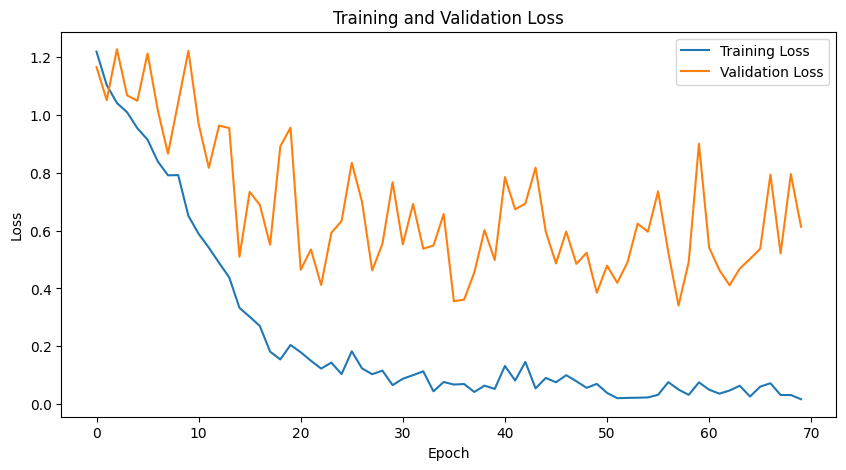

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

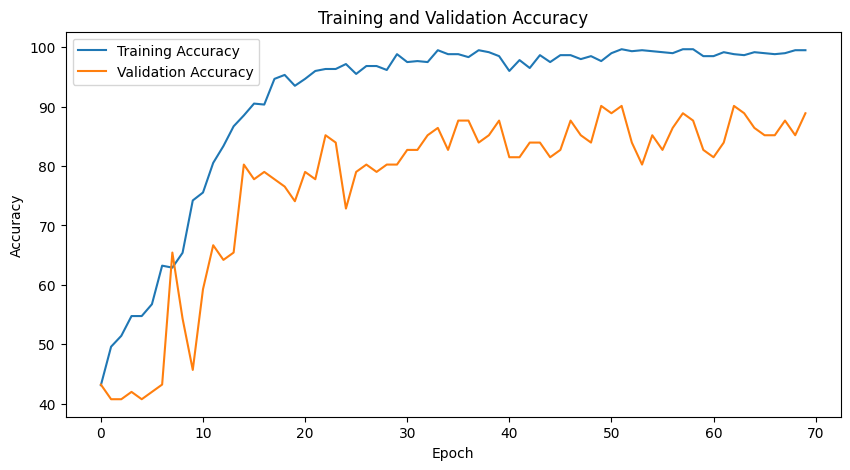

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:

# Hitung rata-rata metrik setelah semua epoch
average_train_loss = np.mean(train_losses)
average_valid_loss = np.mean(valid_losses)
average_train_accuracy = np.mean(train_accuracies)
average_valid_accuracy = np.mean(valid_accuracies)
average_train_precision = np.mean(train_precisions) # Calculate mean from stored values
average_valid_precision = np.mean(valid_precisions) # Calculate mean from stored values
average_train_recall = np.mean(train_recalls)     # Calculate mean from stored values
average_valid_recall = np.mean(valid_recalls)     # Calculate mean from stored values
average_train_f1 = np.mean(train_f1s)           # Calculate mean from stored values
average_valid_f1 = np.mean(valid_f1s)           # Calculate mean from stored values



# Display results training
print('--------------')
print(f'Training Accuracy: {average_train_accuracy:.2f}%')
print(f'Training Loss: {average_train_loss:.4f}')
print(f'Training Precision: {average_train_precision:.4f}')
print(f'Training Recall: {average_train_recall:.4f}')
print(f'Training F1-Score: {average_train_f1:.4f}')


# Display results validasi
print('--------------')
print(f'Validation Accuracy: {average_valid_accuracy:.2f}%')
print(f'Validation Loss: {average_valid_loss:.4f}')
print(f'Validation Precision: {average_valid_precision:.4f}')
print(f'Validation Recall: {average_valid_recall:.4f}')
print(f'Validation F1-Score: {average_valid_f1:.4f}')

--------------
Training Accuracy: 90.95%
Training Loss: 0.2364
Training Precision: 0.9081
Training Recall: 0.9095
Training F1-Score: 0.9043
--------------
Validation Accuracy: 77.00%
Validation Loss: 0.6776
Validation Precision: 0.8280
Validation Recall: 0.7700
Validation F1-Score: 0.7642


In [ ]:
def debug_pruned_weights(model):
    """
    Print out the number of filters and weights in each layer to ensure pruning is correctly applied.
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            print(f"Layer: {name}, Weights Shape: {module.weight.shape}")

# Periksa model setelah pruning
debug_pruned_weights(pruned_model_resnet)


Layer: features.0, Weights Shape: torch.Size([57, 3, 7, 7])
Layer: features.4.0.conv1, Weights Shape: torch.Size([57, 57, 1, 1])
Layer: features.4.0.conv2, Weights Shape: torch.Size([57, 57, 3, 3])
Layer: features.4.0.conv3, Weights Shape: torch.Size([230, 57, 1, 1])
Layer: features.4.0.downsample.0, Weights Shape: torch.Size([230, 57, 1, 1])
Layer: features.4.1.conv1, Weights Shape: torch.Size([57, 230, 1, 1])
Layer: features.4.1.conv2, Weights Shape: torch.Size([57, 57, 3, 3])
Layer: features.4.1.conv3, Weights Shape: torch.Size([230, 57, 1, 1])
Layer: features.4.2.conv1, Weights Shape: torch.Size([57, 230, 1, 1])
Layer: features.4.2.conv2, Weights Shape: torch.Size([57, 57, 3, 3])
Layer: features.4.2.conv3, Weights Shape: torch.Size([230, 57, 1, 1])
Layer: features.5.0.conv1, Weights Shape: torch.Size([115, 230, 1, 1])
Layer: features.5.0.conv2, Weights Shape: torch.Size([115, 115, 3, 3])
Layer: features.5.0.conv3, Weights Shape: torch.Size([460, 115, 1, 1])
Layer: features.5.0.down

In [ ]:
# Test the model

pruned_model_resnet.load_state_dict(torch.load('/content/drive/MyDrive/Best-pruning-model/11-iterasi-fine_tuned_pruned_resnet-10-0,001.pth'))
pruned_model_resnet.eval()

# Start timer for testing
start_test_time = time.time()

test_loss = 0
all_test_preds = []
all_test_labels = []
correct = 0
total = 0
with torch.no_grad():
  for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # Convert grayscale images to 3 channels
    if images.size(1) == 1:
      images = images.repeat(1, 3, 1, 1)

    outputs = pruned_model_resnet(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()

    all_test_preds.append(outputs)
    all_test_labels.append(labels)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(torch.cat(all_test_preds), torch.cat(all_test_labels))
print("\n---------------------------------------------------------------------------------------------\n")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

# End timer for testing and print the total time
end_test_time = time.time()
total_testing_time = end_test_time - start_test_time
print(f"Total Testing Time: {total_testing_time:.2f} seconds")

<ipython-input-13-9efca0bb5318>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruned_model_resnet.load_state_dict(torch.load('/content/drive/MyDrive/Best-pruning-model/fi


---------------------------------------------------------------------------------------------

Test Loss: 0.5852, Accuracy: 82.86%, Precision: 0.8461, Recall: 0.8286, F1-Score: 0.8301
Total Testing Time: 1.89 seconds


<ipython-input-14-e2c4ee36997a>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruned_model_resnet.load_state_dict(torch.load('/content/drive/MyDrive/Best-pruning-model/fi

Total testing time: 1.66 seconds
Test Accuracy: 82.86%
Test Loss: 0.0754
Precision: 0.8461
Recall: 0.8286
F1-Score: 0.8301
Confusion Matrix:
[[90 15  0 15]
 [ 1 50  0  0]
 [ 3  0 51  0]
 [ 9 11  0 70]]


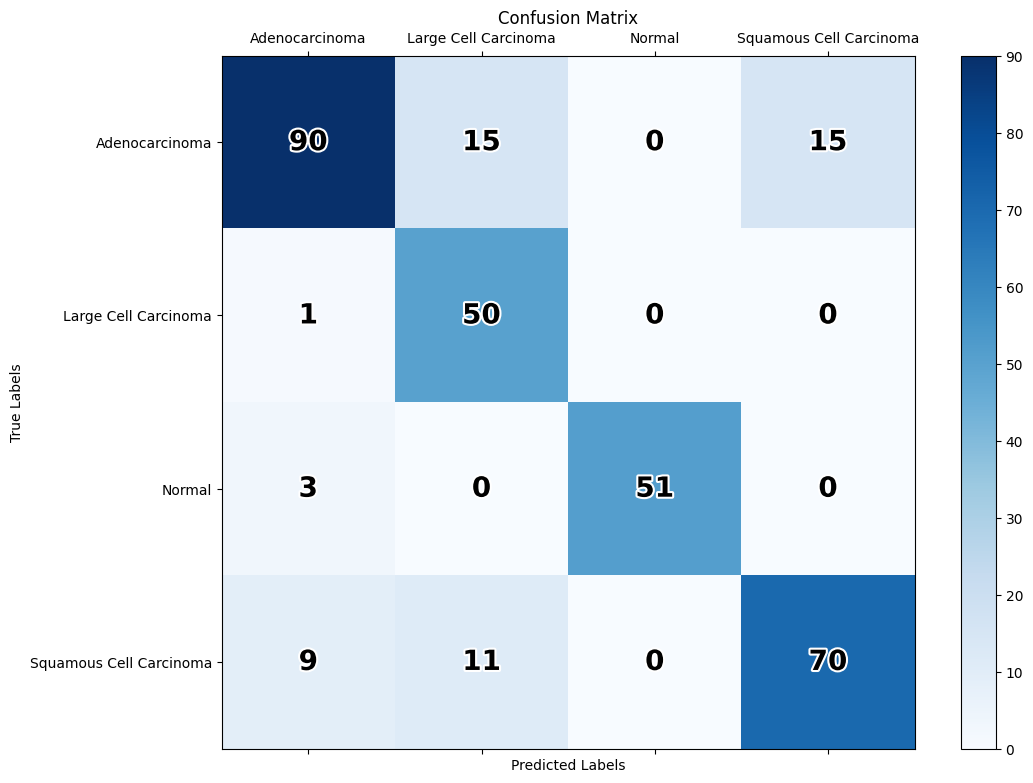

In [ ]:
# Path dinamis untuk memuat model terbaik
#best_model_file = '/content/drive/MyDrive/Chest-CT-Data/best-model-vgg-clahe-0,001.pth' if IN_COLAB else 'best-model.pth'
# Start testing time
testing_start_time = time.time()

# Load the best model
pruned_model_resnet.load_state_dict(torch.load('/content/drive/MyDrive/Best-pruning-model/11-iterasi-fine_tuned_pruned_resnet-10-0,001.pth'))
pruned_model_resnet.eval()

# Define class labels corresponding to the numerical labels
class_labels = [
    'Adenocarcinoma',
    'Large Cell Carcinoma',
    'Normal',
    'Squamous Cell Carcinoma'
]

predicted_probabilities = []
true_labels = []

test_loader_tqdm = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for images, labels in test_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        if images.dim() == 3:
            images = images.unsqueeze(1)
        images = images.repeat(1, 3, 1, 1)
        outputs = pruned_model_resnet(images)
        loss = criterion(outputs, labels)
        probabilities = nn.functional.softmax(outputs, dim=1)
        predicted_probabilities.append(probabilities)
        true_labels.append(labels)
        #test_loader_tqdm.set_postfix({"Batch Size": len(labels)})

# End testing time
total_testing_time = time.time() - testing_start_time
print(f"Total testing time: {total_testing_time:.2f} seconds")

# Calculate evaluation metrics
predicted_probabilities = torch.cat(predicted_probabilities)
true_labels = torch.cat(true_labels)
predicted_labels = torch.argmax(predicted_probabilities, dim=1)

accuracy = (predicted_labels == true_labels).float().mean().item()
precision = precision_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
recall = recall_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
f1 = f1_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
conf_matrix = confusion_matrix(true_labels.cpu(), predicted_labels.cpu())

# Display results
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test Loss: {loss:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Plot confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(12, 9))
cax = ax.matshow(conf_matrix, cmap='Blues')

# Menampilkan angka pada setiap sel dengan outline putih
for (i, j), val in np.ndenumerate(conf_matrix):
    text = ax.text(j, i, f'{val}', ha='center', va='center', color='black', fontsize=20, fontweight='bold')

    # Menambahkan outline putih di sekitar angka
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                           path_effects.Normal()])

fig.colorbar(cax)

# Set ticks dan ticklabels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Total time for the whole process
#total_process_time = total_training_time + total_testing_time
#print(f"Total process time (training + testing): {total_process_time:.2f} seconds")


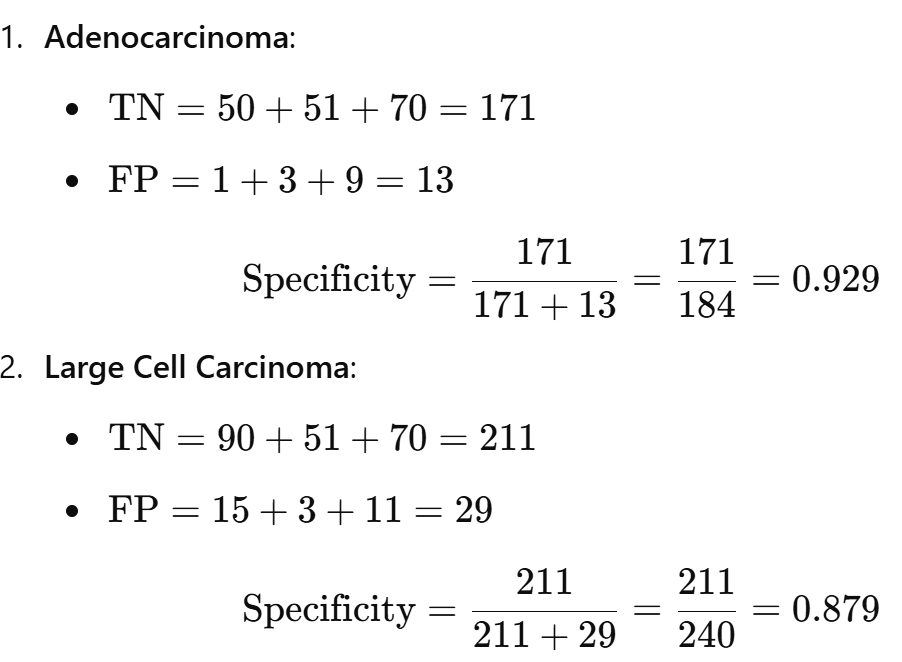

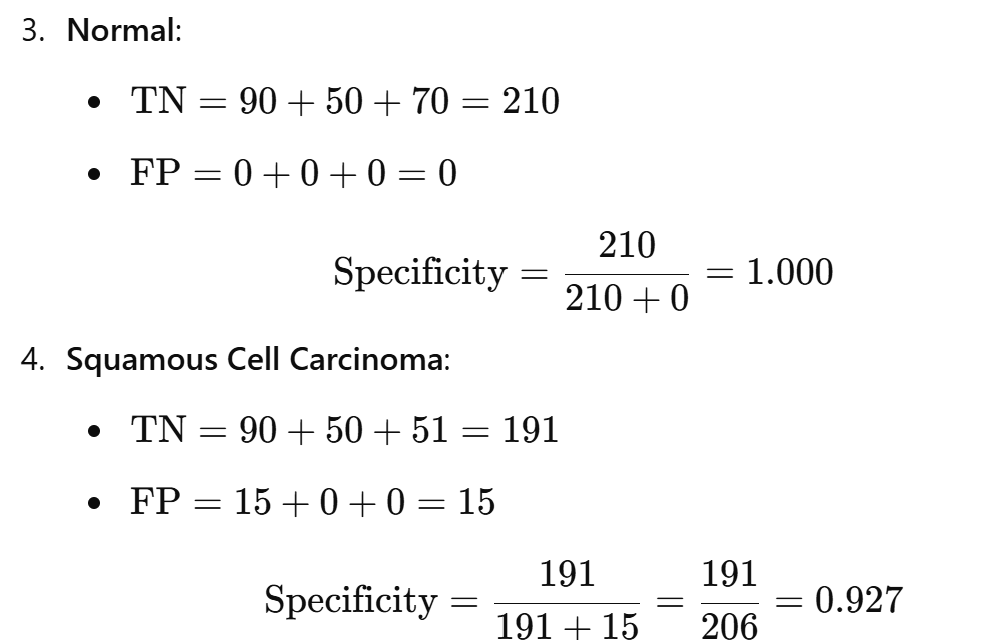

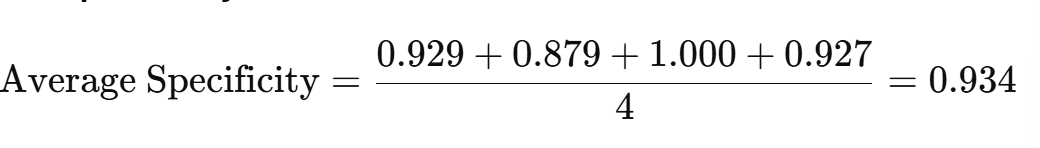

In [ ]:
# Test the model

pruned_model_resnet.load_state_dict(torch.load('/content/drive/MyDrive/Best-pruning-model/11-iterasi-best-pruned-resnet-10-0,001.pth'))
pruned_model_resnet.eval()

test_loss = 0
all_test_preds = []
all_test_labels = []
correct = 0
total = 0
with torch.no_grad():
  for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # Convert grayscale images to 3 channels
    if images.size(1) == 1:
      images = images.repeat(1, 3, 1, 1)

    outputs = pruned_model_resnet(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()

    all_test_preds.append(outputs)
    all_test_labels.append(labels)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(torch.cat(all_test_preds), torch.cat(all_test_labels))
print("\n---------------------------------------------------------------------------------------------\n")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

<ipython-input-15-ab301a7adff8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruned_model_resnet.load_state_dict(torch.load('/content/drive/MyDrive/Best-pruning-model/be


---------------------------------------------------------------------------------------------

Test Loss: 0.6166, Accuracy: 80.00%, Precision: 0.8112, Recall: 0.8000, F1-Score: 0.7982
